# **Version Description**

In [1]:
#if any description to be included

# **Model Basic Parameters**

In [2]:
trainer_epochs = 50
batch_size_train = 4
batch_size_valid = 4
train_valid_ratio = 0.8
current_model_name = "vipcup24_denoising_with_unet"

# **Dataset Class**

In [3]:
import pandas as pd
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 as cv
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class dataset_class(Dataset):

    def __init__(self, train, img_paths, fold, num, mode='odd'):
        self.train = train
        self.img_paths = img_paths
        self.fold = fold
        self.num = num
        self.transforms = None
        self.mode = mode
        self.mask150 = np.zeros((300,150))
        self.mask150_ = np.ones((300,150))
        for i in range(0,300,2):
            for j in range(0,150,2):
                self.mask150[i][j]=1
                self.mask150_[i][j]=0
        self.mask200 = np.zeros((300,200))
        self.mask200_ = np.ones((300,200))
        for i in range(0,300,2):
            for j in range(0,200,2):
                self.mask200[i][j] = 1
                self.mask200_[i][j] = 0
        if self.train==True:
            self.transforms = A.Compose([
                    #A.HorizontalFlip(p=0.5),
                    #A.VerticalFlip(p=0.5),
                    ToTensorV2()
                ])
        else :
            # validation transform
            self.transforms = transforms.Compose([
                                ToTensorV2()
                            ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]        
        original = Image.open(path).convert("L")
        original = np.array(original,dtype = np.float32)
        if original.shape[1]==150:
            if self.mode=='odd':
                image = original*self.mask150
                label = original*self.mask150_
            else:
                image = original*self.mask150_
                label = original*self.mask150
            image = np.pad(np.repeat(image,2,1),2)/255.00
            label = np.pad(np.repeat(label,2,1),2)/255.00
        else:
            if self.mode=='odd':
                image = original*self.mask200
                #label = original*self.mask200_
                label = original
            else:
                image = original*self.mask200_
                #label = original*self.mask200
                label = original
            image = np.pad(image,((2,2),(0,0)))/255.00
            label = np.pad(label,((2,2),(0,0)))/255.00
#         augmentations = self.transforms(image=image)
#         image = augmentations["image"]
        augmentation = self.transforms(image=image, mask=label)
        image = augmentation["image"].type(torch.FloatTensor)
        label = augmentation["mask"].type(torch.FloatTensor)
        
        label = label.unsqueeze(0)
        return image,label,self.fold[idx], self.num[idx]

# **Dataset Creation**

**Train and Validation dataset**

In [4]:
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/vip-cup-2024-train-test-dataset/ICIP_test_data_final'
image_dirs = []
img_fold = []
img_num = []
for j in os.listdir(data_dir):
    if '.pdf' in j: 
        continue
    k = j.find('(')
    fold = int(j[k+1])
    if j[k+2]!=')':
        fold = fold*10+int(j[k+2])
    for i in os.listdir(os.path.join(data_dir,j)):
        if '.tif' in i:
            num = int(i[1])
            if i[2]!=')':
                num = num*10+int(i[2])
                if i[3]!=')':
                    num = num*10+int(i[3])
            path = os.path.join(data_dir,j,i)
            img = cv.imread(path)
            if img.shape[1]==200:
                image_dirs.append(path)
                img_fold.append(fold)
                img_num.append(num)


In [5]:
train_dataset_1 = dataset_class(True, img_paths = image_dirs, fold=img_fold, num=img_num, mode='odd')
train_dataset_2 = dataset_class(True, img_paths = image_dirs, fold=img_fold, num=img_num, mode='even')

**Dataset checking**

In [6]:
'''
for i in range(len(train_dataset)):
    x = train_dataset[i][0]
    y = train_dataset[i][1]
    if x.shape == torch.Size([1,300,300]) and y.shape == torch.Size([3]):
        continue
    else:
        print(f"problem on {i}th")
'''
train_dataset_1.__len__()

1746

# **MODEL ClASS**

In [7]:
import torchvision.models as models
from torchinfo import summary
import torch.nn as nn

import torch.nn as nn
import torch

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2

class ResUnetPlusPlus(nn.Module):
    def __init__(self, channel, filters=[32, 64, 128, 256, 512]):
        super(ResUnetPlusPlus, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        # self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 1, 1), nn.Sigmoid())
        self.output_layer = nn.Conv2d(filters[0], 1, 1)

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out


# Device

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **Trainer Function**

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import sys
import time
import torch
import sklearn
from tqdm.notebook import tqdm
def train_supervised(train_loader,model,criterion,optimizer,epoch,device):
    
    model.train()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch}] - Learning Rate: {current_lr}")
    total_batches = len(train_loader)        
    losses = AverageMeter()
    device = device    
    steps = 0
    print(f"total steps: {total_batches}")
    
    for _, (images,label, _, _) in enumerate(train_loader):        
        images = images.to(device)
        label = label.to(device)
        output = torch.sigmoid(model(images))
        #print(torch.max(output), torch.min(output))
        #print(output)
        #print(f"out_mask shape: {out_masks['out'].size()}")
        loss = torch.sqrt(criterion(output, label))          
        #loss = loss3
        epoch_loss = loss.item()
        bsz = images.shape[0]
        #losses.update(loss.item(), bsz)
        losses.update(epoch_loss, bsz)        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        if steps%50 == 0:
            print(f"step no: {steps} and loss : {losses.avg}")
        steps = steps+1
    return losses.avg

# **VALIDATOR**

In [13]:
import numpy as np
from PIL import Image

#_subject_counter = torch.zeros(size=(3,100),dtype=torch.int32)
#_subject_sample = torch.zeros(size=(3,100),dtype=torch.int32)
def validator(valid_loader, model, deivce):
    model.eval()
    #print(valid_loader.__len__())
    data = np.zeros((20,300,300,200),dtype=np.float32)
    original = np.zeros((20,300,300,200),dtype=np.float32)
    for _, (images, label, fold, num) in enumerate(valid_loader):
        #print(images.shape)
        #print(label.shape)
        #print(idx)
        images = images.to(device)
        output = model(images)
        output = torch.sigmoid(output)    
        output = output.squeeze().detach().cpu().numpy()
        images = images.squeeze().detach().cpu().numpy()
        temp = output[:,2:302,:]
        tmp = images[:,2:302,:]
        #print(output.shape)
        #print(temp.shape)
        for i in range(fold.__len__()):
            data[fold[i]][num[i]]=temp[i]
            original[fold[i]][num[i]]=tmp[i]
    return data, original

# **Data Loader**

In [11]:
# dataloader
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=batch_size_train, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=batch_size_train, shuffle=True)

# **Training Loop 1**

In [ ]:
from torch import optim 
import torch.optim.lr_scheduler as lr_scheduler

epoch_train_loss=[]
epochs = trainer_epochs
epochs = 15
modelx = ResUnetPlusPlus(channel=1).to(device)
#criterion = torch.nn.BCEWithLogitsLoss().to(device)
criterion = torch.nn.MSELoss().to(device)
#optimizer = optim.SGD(model.parameters(),lr=0.05,momentum=0.9,weight_decay=1e-4)
optimizer = optim.Adam(modelx.parameters(), lr=0.0001)
milestones = [5, 10, 15]  # Learning rate will be adjusted at these epochs
gamma = 0.5  # Learning rate will be multiplied by this factor at each milestone
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
best_result = 0
model_path = f"{current_model_name}.pth"

for epoch in range(1,epochs+1):
    train_loss = train_supervised(train_loader_1,modelx,criterion,optimizer,epoch,device)
    scheduler.step() # Step the scheduler
    print(f"train loss for epoch {epoch}: {train_loss}")
data_1 = validator(train_loader_1, modelx, device)

# **Training Loop 2**

In [ ]:
from torch import optim 
import torch.optim.lr_scheduler as lr_scheduler

epoch_train_loss=[]
epochs = trainer_epochs
epochs = 15
model = ResUnetPlusPlus(channel=1).to(device)
criterion = torch.nn.MSELoss().to(device)
#optimizer = optim.SGD(model.parameters(),lr=0.05,momentum=0.9,weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
milestones = [5, 10, 15]  # Learning rate will be adjusted at these epochs
gamma = 0.5  # Learning rate will be multiplied by this factor at each milestone
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
best_result = 0
model_path = f"{current_model_name}.pth"

for epoch in range(1,epochs+1):
    train_loss = train_supervised(train_loader_2,model,criterion,optimizer,epoch,device)
    scheduler.step() # Step the scheduler
    print(f"train loss for epoch {epoch}: {train_loss}")

#data_2 = validator(train_loader_2, model, device)

In [15]:
data_1, org_1 = validator(train_loader_1, modelx, device)
data_2, org_2 = validator(train_loader_2, model, device)

In [16]:
data_11 = np.copy(data_1)
data_22 = np.copy(data_2)
org_11 = np.copy(org_1)
org_22 = np.copy(org_2)

In [18]:
print(org_11.shape)

(20, 300, 300, 200)


In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

t = 1

In [54]:
out_dir = '/kaggle/working/denoised/'
sr_dir = '/kaggle/working/sr/'
os.makedirs(out_dir)
os.makedirs(sr_dir)

In [55]:
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/vip-cup-2024-train-test-dataset/ICIP_test_data_final'

for j in os.listdir(data_dir):
    os.makedirs(os.path.join(out_dir,j))
    os.makedirs(os.path.join(sr_dir,j))
    if '.pdf' in j: 
        continue
    k = j.find('(')
    fold = int(j[k+1])
    if j[k+2]!=')':
        fold = fold*10+int(j[k+2])
    for i in os.listdir(os.path.join(data_dir,j)):
        if '.tif' in i:
            num = int(i[1])
            if i[2]!=')':
                num = num*10+int(i[2])
                if i[3]!=')':
                    num = num*10+int(i[3])
            path = os.path.join(data_dir,j,i)
            img = cv.imread(path)
            if img.shape[1]==200:
                y = data_1[fold][num]+data_2[fold][num]
                y = y - 0.05*np.sin(2*np.pi*y)
                y = np.exp(y)
                plt.figure(figsize=(10,10))
                plt.imshow(y,cmap='gray',interpolation='none')
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                plt.savefig(fname=os.path.join(out_dir,j,i),transparent=True,bbox_inches='tight',pad_inches=0,dpi=39)
                plt.close()
                
                img = Image.fromarray(y).resize((300,300))
                y = np.array(img)
                plt.figure(figsize=(10,10))
                plt.imshow(y,cmap='gray',interpolation='none')
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                plt.savefig(fname=os.path.join(sr_dir,j,i),transparent=True,bbox_inches='tight',pad_inches=0,dpi=39)
                plt.close()

In [ ]:
import zipfile
import sys
import os

def zip_folder(folder_path, output_path):
    """Zip the contents of an entire folder (with that folder included
    in the archive). Empty subfolders will be included in the archive
    as well.
    """
    parent_folder = os.path.dirname(folder_path)
    # Retrieve the paths of the folder contents.
    contents = os.walk(folder_path)
    try:
        zip_file = zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED)
        for root, folders, files in contents:
            # Include all subfolders, including empty ones.
            for folder_name in folders:
                absolute_path = os.path.join(root, folder_name)
                relative_path = absolute_path.replace(parent_folder + '\\',
                                                      '')
                print("Adding '%s' to archive." % absolute_path)
                zip_file.write(absolute_path, relative_path)
            for file_name in files:
                absolute_path = os.path.join(root, file_name)
                relative_path = absolute_path.replace(parent_folder + '\\',
                                                      '')
                print("Adding '%s' to archive." % absolute_path)
                zip_file.write(absolute_path, relative_path)
        print("'%s' created successfully." % output_path)
    except IOError, message:
        print message
        sys.exit(1)
    except OSError, message:
        print message
        sys.exit(1)
    except zipfile.BadZipfile, message:
        print message
        sys.exit(1)
    finally:
        zip_file.close()

zip_folder("/kaggle/working/denoised", "denoised.zip")

In [56]:
! zip "denoised.zip" "/kaggle/working/denoised"

  adding: kaggle/working/denoised/ (stored 0%)


(300, 200)


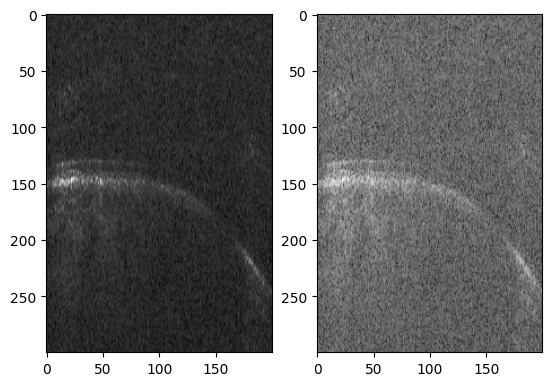

In [52]:
import matplotlib.pyplot as plt


%matplotlib inline

data_x1 = np.copy(data_1)
data_x2 = np.copy(data_2)
data_x1[:,:,0:300:2,0:200:2] = 0
data_x2[:,:,1:300:2,1:200:2] = 0
y = data_1[7][t]+data_2[7][t]
y = y - 0.05*np.sin(2*np.pi*y)
y = np.exp(y)
#y = np.expand_dims(y,axis=0)
print(y.shape)
img = Image.fromarray(y).resize((300,300))
plt.subplot(1,2,1)
xx = plt.imshow(y, cmap='gray')
plt.subplot(1,2,2)
yy = plt.imshow(org_1[7][t]+org_2[7][t],cmap='gray')

(300, 300)


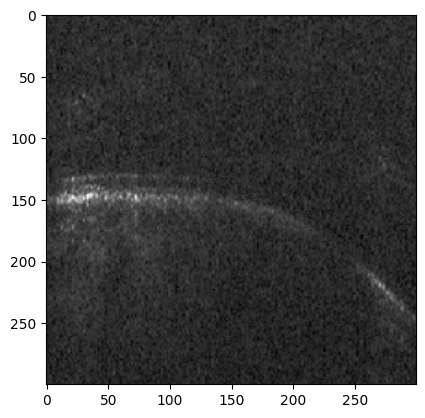

In [53]:
val = np.array(img)
print(val.shape)

%matplotlib inline
plt.imshow(val,cmap='gray')

In [ ]:
yy = plt.imshow(org_1[t]+org_2[t],cmap='gray')

In [ ]:
data_x1 = data_1
data_x2 = data_2
data_x1[:,0:300:2,0:200:2] = 0
data_x2[:,1:300:2,1:200:2] = 0

In [ ]:
mx = np.max(data_1[t]+data_2[t])
xx = plt.imshow(np.exp((data_1[t]+data_2[t])), cmap='gray')